In [91]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [92]:
test = pd.read_csv('../data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [93]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [94]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [95]:
train.shape

(2935849, 10)

In [96]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [97]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [98]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [99]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [100]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [101]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [102]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [103]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [104]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00


In [105]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
count,6734448.00,6734448.00,6734448.00,6734448.00,6734448.00,6734448.00,6734448.00,6734448.00,6734448.00
mean,16.50,31.64,11041.89,3.79,187.35,81.13,0.24,0.10,0.18
std,9.81,17.56,6210.74,13.21,2171.80,531.16,3.46,0.61,0.90
min,0.00,2.00,30.00,0.00,0.00,0.00,-4.00,-2.00,0.00
25%,8.00,16.00,5385.25,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.50,34.50,11265.50,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,47.00,16068.25,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,515573.59,42990.00,2253.00,1000.00,31.00


In [106]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [107]:
train_monthly = train_monthly[
        (train_monthly["item_price"] > 0) & (train_monthly["item_cnt"] > 0)
    ]

In [108]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
count,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00,598994.00
mean,20.16,32.06,10016.57,42.50,2101.24,909.17,2.70,1.09,2.04,2014.22,5.54
std,9.14,16.89,6192.93,17.74,7016.86,1562.69,11.30,1.77,2.32,0.77,3.36
min,0.00,2.00,30.00,2.00,0.50,0.50,1.00,0.20,1.00,2013.00,0.00
25%,13.00,19.00,4397.00,30.00,299.00,299.00,1.00,1.00,1.00,2014.00,3.00
50%,22.00,31.00,9151.00,40.00,745.00,472.57,1.00,1.00,1.00,2014.00,6.00
75%,28.00,47.00,15375.00,55.00,1849.00,1099.00,2.00,1.00,2.00,2015.00,8.00
max,33.00,59.00,22167.00,83.00,515573.59,42990.00,2253.00,1000.00,31.00,2015.00,11.00


In [71]:
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

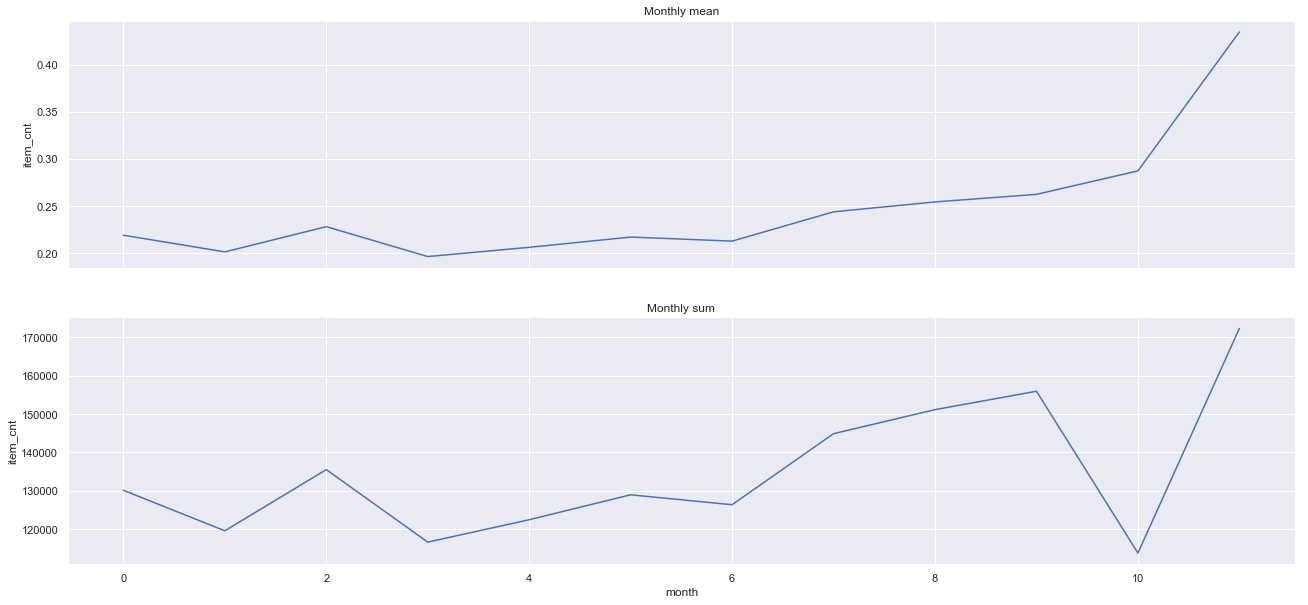

In [22]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

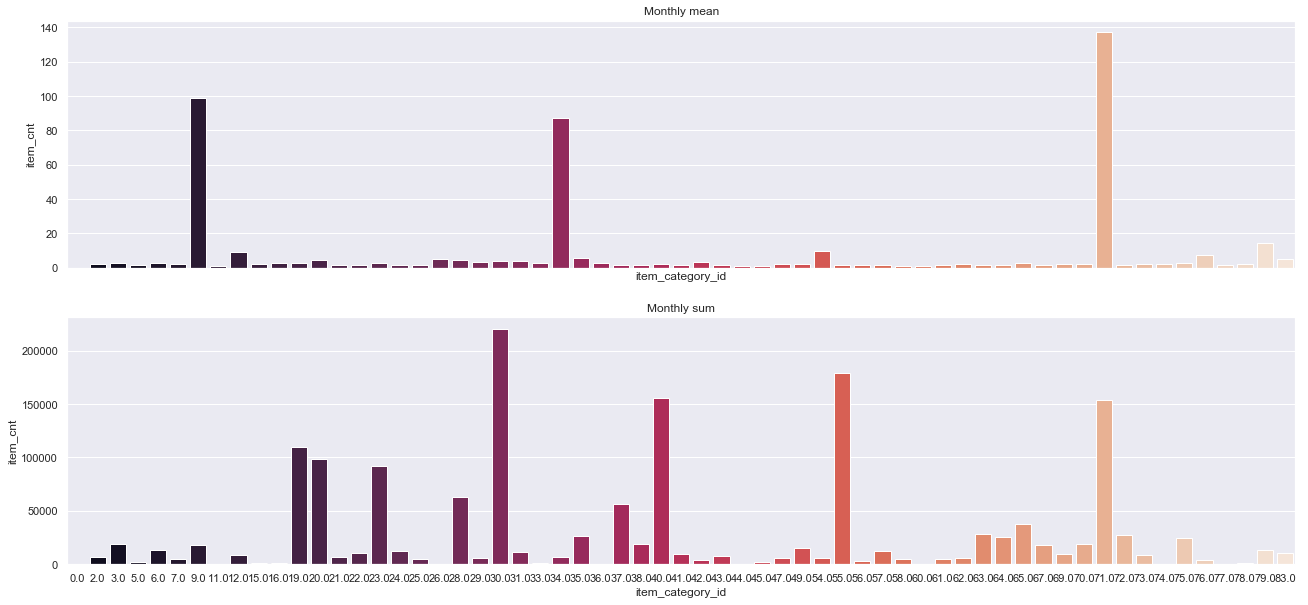

In [23]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

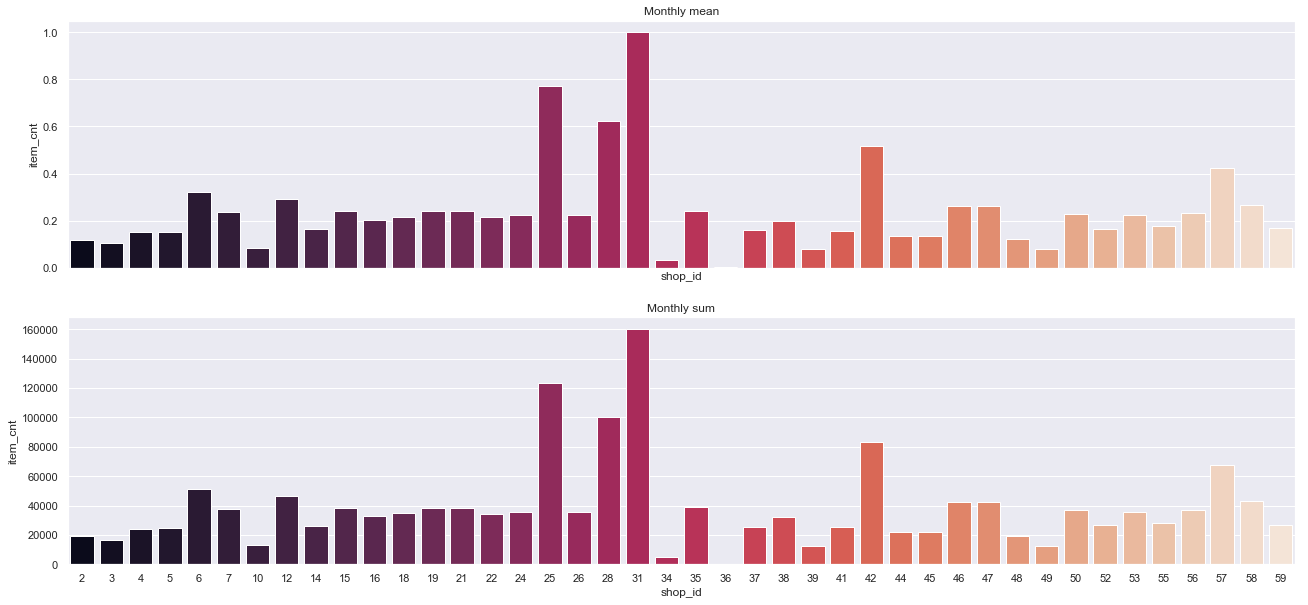

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

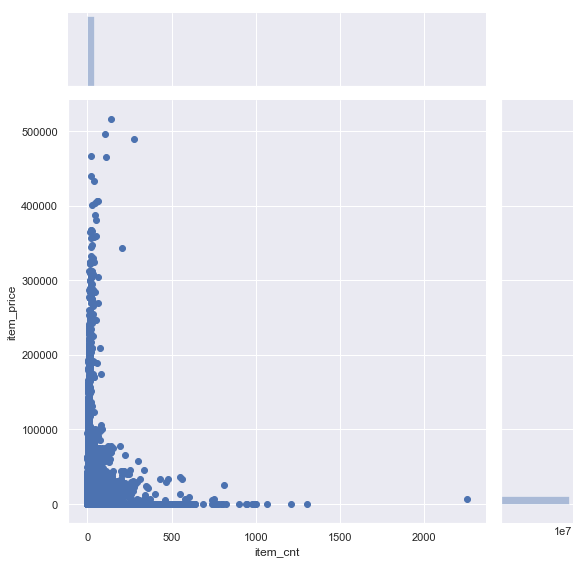

In [25]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

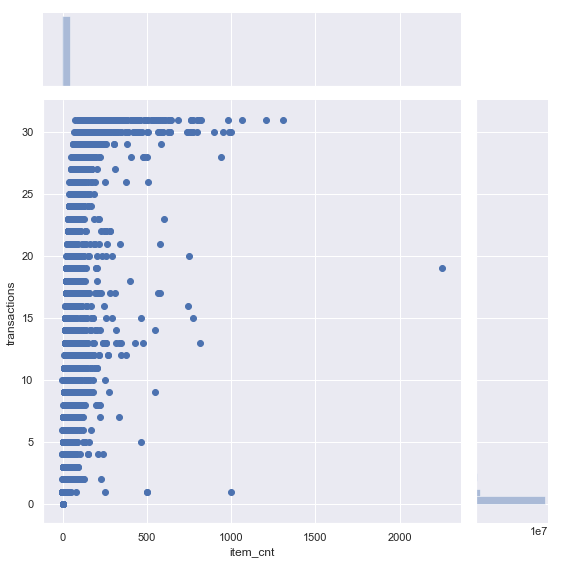

In [26]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

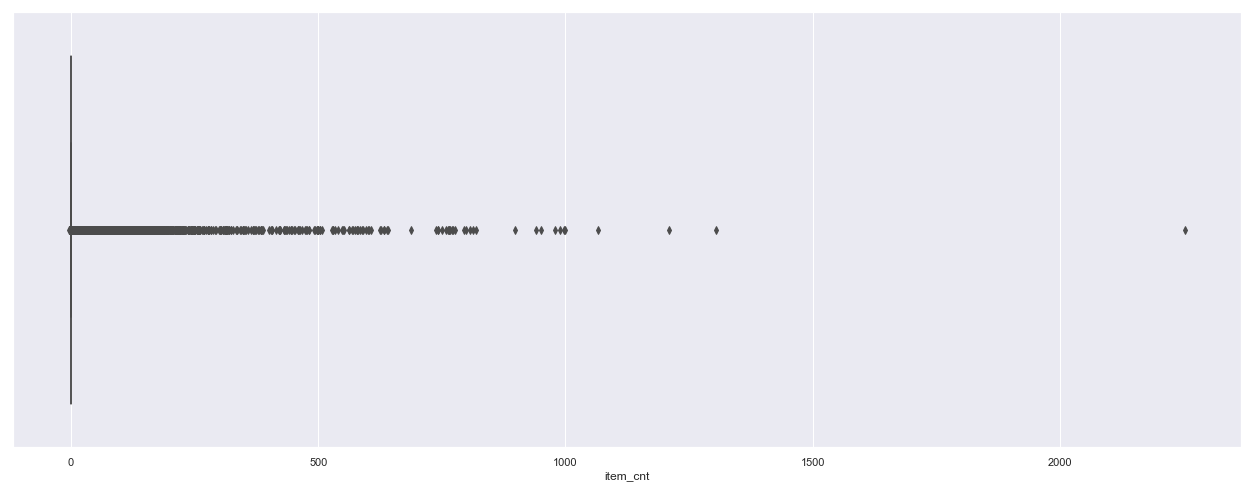

In [27]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [111]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

In [122]:
train_monthly.query('date_block_num == 34')

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month


In [123]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [124]:
train_monthly.query('date_block_num == 34')

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month


In [114]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00
5,0,2,7895,6.00,2697.00,899.00,4.00,1.33,3.00,2013,0,1.00


In [125]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [126]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [127]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [33]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [34]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [35]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [36]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,5970.00,21980.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,24390.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25


In [37]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,...,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00
mean,16.50,31.64,11042.87,3.75,169.77,79.71,0.19,0.09,0.17,2013.94,...,169.77,5396.74,0.14,0.26,0.20,0.07,0.16,0.14,0.13,-0.06
std,9.81,17.56,6209.70,13.16,1792.01,522.27,0.91,0.31,0.74,0.80,...,1792.01,11022.27,0.69,1.25,0.92,0.44,0.88,0.85,0.82,0.44
min,0.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.50
25%,8.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,999.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,...,0.00,2396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,47.00,16068.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,366860.00,42990.00,20.00,20.00,19.00,2015.00,...,366860.00,366860.00,20.00,20.00,20.00,13.44,20.00,20.00,20.00,5.00


In [38]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


In [39]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [40]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [41]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [42]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [43]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [44]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [45]:
X_test.head()

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5.00,5037.00,749.50,749.50,1.00,1.00,1.00,2015.00,9.00,749.00,...,1.15,3.00,1.00,1.00,-1.00,0.13,0.70,0.28,0.22,0.17
1,5.00,5320.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.05,0.00,0.22,0.17
2,5.00,5233.00,2997.00,999.00,3.00,1.00,3.00,2015.00,9.00,999.00,...,1.00,1.00,2.00,3.00,-0.75,0.13,0.07,0.12,0.22,0.17
3,5.00,5232.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.22,0.17
4,5.00,5268.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.05,0.00,0.22,0.17


In [46]:
X_test.describe()

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
count,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,...,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00,214200.00
mean,31.64,11019.40,239.98,133.82,0.23,0.13,0.20,2015.00,9.00,inf,...,0.08,0.21,0.18,0.17,-0.08,0.19,0.18,0.18,0.22,0.17
std,17.56,6252.64,1854.07,865.39,0.95,0.37,0.73,0.00,0.00,nan,...,0.43,0.91,0.83,0.85,0.46,0.13,0.41,0.56,0.00,0.00
min,2.00,30.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,-11.00,0.00,0.00,0.00,0.14,0.14
25%,16.00,5381.50,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.12,0.01,0.00,0.22,0.17
50%,34.50,11203.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.05,0.00,0.22,0.17
75%,47.00,16071.50,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.20,0.18,0.12,0.22,0.17
max,59.00,22167.00,166944.50,32990.00,20.00,10.00,15.00,2015.00,9.00,inf,...,12.02,20.00,20.00,20.00,5.00,0.68,6.97,20.00,0.22,0.21


In [ ]:
X_test.fillna(0)

In [48]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [49]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0, gpu_id=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[08:37:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.84444	validation_1-rmse:0.88123
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.67778	validation_1-rmse:0.81829
Stopping. Best iteration:
[4]	validation_0-rmse:0.69764	validation_1-rmse:0.79801



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [50]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [51]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.697475453300762
Validation rmse: 0.798117433161014


In [ ]:
# prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
# prediction_df['item_cnt_month'] = xgb_test_pred.clip(0., 20.)
# prediction_df.to_csv('submission.csv', index=False)
# prediction_df.head(10)